**Exploratory analysis of the dataset.**

We are interested in identifying factors that correlate with user ratings of board games. The dataset contains the following variables of interest:

- Release Year
- Weight
- Owners
- Registration Year

The hypothesis is thus that a user's rating for a given board game is correlated with the game's release year, weight, and total owners as well as the user's registration year. We will set $\alpha$ = 0.05 and use the Holm-Bonferonni correction for multiple hypothesis testing.

In [121]:
# import required libraries
import pickle as pickle
import math as math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox_normplot
from sklearn import linear_model
import statsmodels.api as sm

# change notebook figure sizes
plt.rcParams['figure.figsize'] = [10, 7]

# load the dataset
with open("Objects/20181120_sample_pickle", "rb") as file:
    bgg_data = pickle.load(file)
    
# cast the dataset's columns into the appropriate type
bgg_data[["Rating", "Weight", "Average Rating"]] = bgg_data[["Rating", "Weight", "Average Rating"]].astype(float)
bgg_data[["ID", "Rating Number", "Release Year", "Owners", "Registration Year"]] = bgg_data[["ID", "Rating Number", "Release Year", "Owners", "Registration Year"]].astype(int)

In [10]:
bgg_data.dtypes

ID                     int32
Rating Number          int32
Rating               float64
Username              object
Name                  object
Release Year           int32
Weight               float64
Owners                 int32
Average Rating       float64
Registration Year      int32
Last Login            object
dtype: object

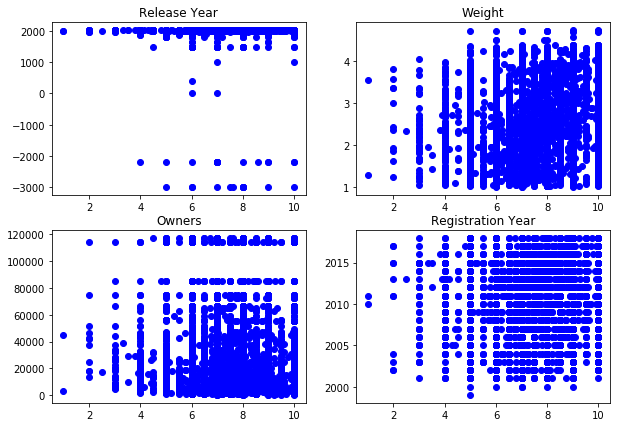

In [11]:
## generate scatterplots of the four variables of interest versus rating
# breakout the needed columns from the larger dataset
to_plot = bgg_data[["Release Year", "Weight", "Owners", "Registration Year"]]

# initialize a plot
plt.figure()

# build subplots for each relationship
for i in range(len(to_plot.columns)):
    # set the plot's position in a 2 x 2 grid
    plt.subplot(2, 2, i + 1)
    
    # plot the column versus rating
    plt.plot(bgg_data["Rating"], to_plot[to_plot.columns[i]], 'bo')
    dd
    # title subplot by column name
    plt.title(to_plot.columns[i])
    
plt.show()

We immediately see a couple of issues to address.

First, there are a number of dramatic release year outliers. We might reasonably assume that user ratings for ancient games such as Chess or Go are driven by different factors than user ratings for games released in the "modern" board game era (~1990 to present). To this end, removing these observations from the dataset and reframing our hypotheses to cover just the modern era is a reasonable approach.

Second, the clear "bar" pattern along the rating axis indicates that the user ratings are perhaps closer to ordinal than continuous. Indeed, when we look at the distribution of user ratings, we find that the vast majority of ratings fall directly on an integer value. We have several options to address this. Most directly, we could round the observed user ratings to the nearest integer value proceed as if it is true ordinal data. Alternatively, we can further alter our hypothesis from considering raw user rating to considering the difference between user rating and the average rating for the given game, the distribution of which is closer to Guassian. I like the second approach better, as it has the secondary benefit of correcting for the innate "quality" of the game.

Implementing these changes, our hypothesis is now:
For board games released after 1990, the difference between a user's rating for a board game and the game's average rating is correlated with the game's release year, weight, and total owners as well as the user's registration year.

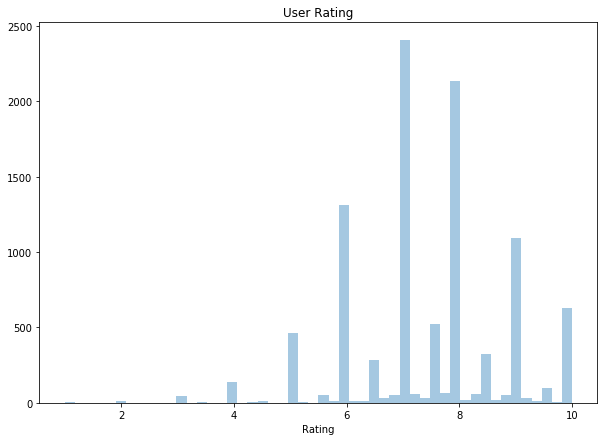

In [12]:
# plot a histogram of the ratings
sns.distplot(bgg_data["Rating"].astype(float), kde = False)
plt.title("User Rating")
plt.show()

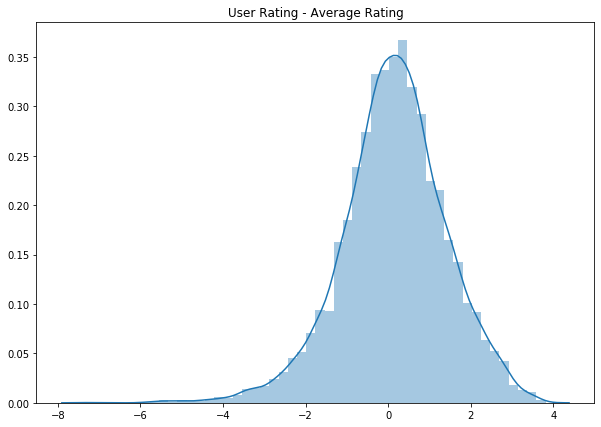

In [13]:
# plot a histogram of user rating - average rating
sns.distplot(bgg_data["Rating"] - bgg_data["Average Rating"])
plt.title("User Rating - Average Rating")
plt.show()

In [14]:
## implementing the changes proposed above
# remove observations with games released prior to 1990 from the dataset
bgg_1990 = bgg_data[bgg_data["Release Year"] >= 1990]

# create a column containing the difference in user and average rating
bgg_1990["Delta Rating"] = bgg_data["Rating"] - bgg_data["Average Rating"]

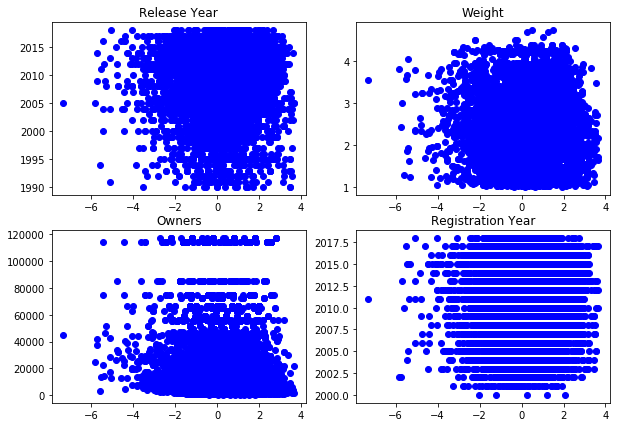

In [15]:
## generate new scatterplots as above with the modified dataset
## now plotting delta rating versus the four variables of interest
# breakout the needed columns from the larger dataset
to_plot = bgg_1990[["Release Year", "Weight", "Owners", "Registration Year"]]

# initialize a plot
plt.figure()

# build subplots for each relationship
for i in range(len(to_plot.columns)):
    # set the subplot's position in a 2 x 2 grid
    plt.subplot(2, 2, i + 1)
    
    # plot the column versus rating
    plt.plot(bgg_1990["Delta Rating"], to_plot[to_plot.columns[i]], 'bo')
    
    # title subplot by column name
    plt.title(to_plot.columns[i])
    
plt.show()

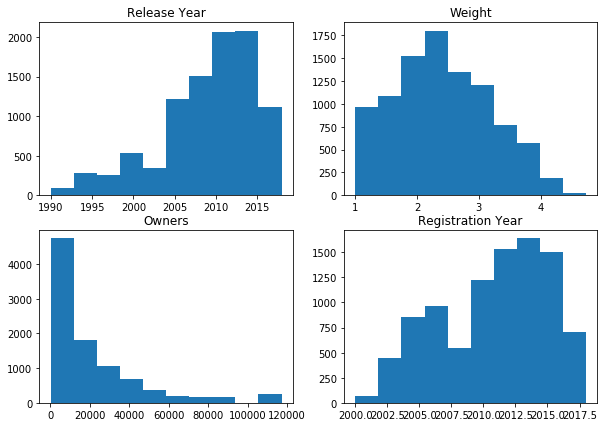

In [16]:
## plot distributions for the four non-rating variables
# breakout the needed columns from the larger dataset
to_plot = bgg_1990[["Release Year", "Weight", "Owners", "Registration Year"]]

# initialize a plot
plt.figure()

# build subplots for each relationship
for i in range(len(to_plot.columns)):
    # set the subplot's position in a 2 x 2 grid
    plt.subplot(2, 2, i + 1)
    
    # plot the column versus rating
    plt.hist(to_plot[to_plot.columns[i]])
    
    # title subplot by column name
    plt.title(to_plot.columns[i])
    
plt.show()

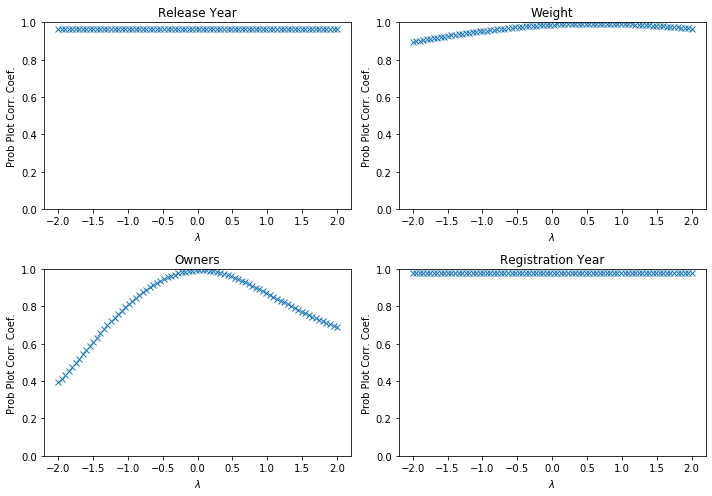

In [43]:
## Box-Cox plots 
# breakout the needed columns from the larger dataset
to_plot = bgg_1990[["Release Year", "Weight", "Owners", "Registration Year"]]

# initialize a plot
fig = plt.figure()

# build subplots for each relationship
for i in range(len(to_plot.columns)):
    # set the subplot's location in a 2 x 2 grid
    ax = fig.add_subplot(2, 2, i + 1)
    
    # add a Box-Cox plot for the variable
    boxcox_normplot(to_plot[to_plot.columns[i]], -2, 2, plot = ax)
    
    # fix the y-axis across plots
    plt.ylim(0, 1)
    
    # title the subplot with the variable name
    plt.title(to_plot.columns[i])

plt.tight_layout()

We will log tranform Owners, the remaining variables look normal enough untransformed.

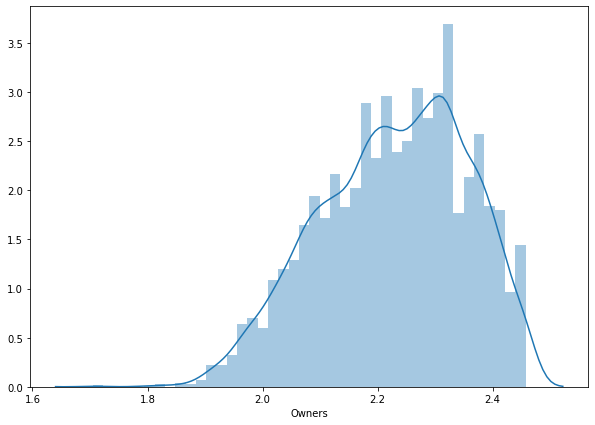

In [58]:
# log transform Owners
bgg_1990["Owners"] = bgg_1990["Owners"].apply(math.log)

# plot a histogram of Owners
sns.distplot(bgg_1990["Owners"])
plt.show()

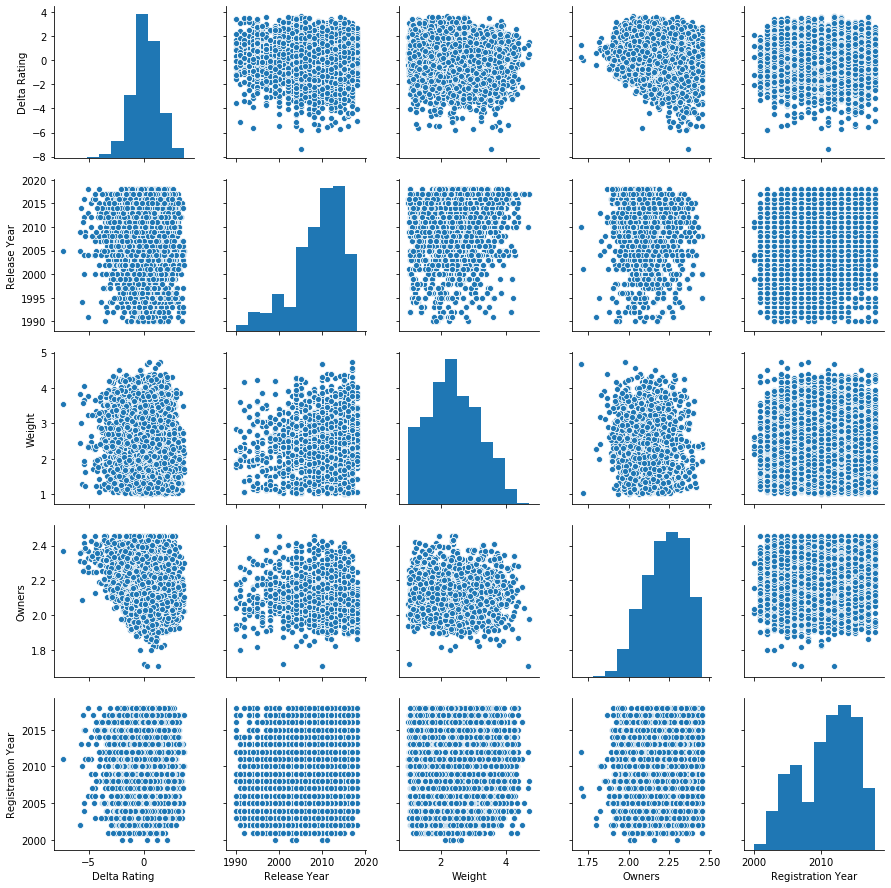

In [59]:
to_plot = bgg_1990[["Delta Rating", "Release Year", "Weight", "Owners", "Registration Year"]]

sns.pairplot(to_plot)
plt.show()

Things look pretty good now - the variables are reasonably close to normally distributed. A simple ordinary least squares linear regression is appropriate here.

In [120]:
## fit an ols linear model for the relationship between delta rating and the other variables
# subset the full dataset
to_fit = bgg_1990[["Release Year", "Weight", "Owners", "Registration Year"]]

# declare an empty list to hold the regression results
model = []

for i in range(len(to_fit.columns)):
    # build arrays for X and Y in the appropriate shape
    X = to_fit[to_fit.columns[i]].as_matrix().reshape(-1, 1)
    Y = bgg_1990["Delta Rating"].as_matrix()
    
    # define and fit the model
    model.append(linear_model.LinearRegression())
    model[i].fit(X, Y)
